In [61]:
import pandas as pd
import numpy as np
from tkinter import Tk
import os
import datetime
import xlsxwriter
import matplotlib.pyplot as plt

In [2]:
locatie = r"C:\Users\hnx\Desktop\Weesp\Secondedata"

In [13]:
df_debiet = pd.read_csv(os.path.join(locatie, "7003 RGI_FTxyz_PW.txt"), sep='|', index_col=0, decimal='.', usecols=[0,1], header=None, names=['sTIme','7003 RGI_FTxyz_PW'])
df_ds = pd.read_csv(os.path.join(locatie, "7009 AT_QT112_AM.txt"), sep='|', index_col=0, decimal='.', usecols=[0,1], header=None, names=['sTIme','7009 AT_QT112_AM'])
df_wl = pd.read_csv(os.path.join(locatie, "7009 AT_LT114_AM.txt"), sep='|', index_col=0, decimal='.', usecols=[0,1], header=None, names=['sTIme','7009 AT_LT114_AM'])
df_lk = pd.read_csv(os.path.join(locatie, "7019 BC_A130_D.txt"), sep='|', index_col=0, decimal='.', usecols=[0,1], header=None, names=['sTIme','7019 BC_A130_D'])
df_ats = pd.read_csv(os.path.join(locatie, "7006 VW_A150_O.txt"), sep='|', index_col=0, decimal='.', usecols=[0,1], header=None, names=['sTIme','7006 VW_A150_O'])

In [14]:
df_debiet.head()

,7003 RGI_FTxyz_PW
sTIme,
2021-04-02T12:00:00.000000Z,338.984161
2021-04-02T12:00:01.000000Z,338.523834
2021-04-02T12:00:02.000000Z,338.836853
2021-04-02T12:00:03.000000Z,339.053894
2021-04-02T12:00:04.000000Z,337.617706


In [17]:
df_debiet.index = pd.to_datetime(df_debiet.index, format='%Y-%m-%dT%H:%M:%S.000000Z')
df_ds.index = pd.to_datetime(df_ds.index, format='%Y-%m-%dT%H:%M:%S.000000Z')
df_wl.index = pd.to_datetime(df_wl.index, format='%Y-%m-%dT%H:%M:%S.000000Z')
df_lk.index = pd.to_datetime(df_lk.index, format='%Y-%m-%dT%H:%M:%S.000000Z')
df_ats.index = pd.to_datetime(df_ats.index, format='%Y-%m-%dT%H:%M:%S.000000Z')


In [23]:
df = pd.concat([df_debiet, df_ds, df_wl, df_lk, df_ats], axis=1)

In [141]:
print(df.index[0])
print(df.index[-1])

2021-04-02 12:00:00
2021-04-13 06:59:59


In [27]:
opp = 1401
df["Influentdebiet1"] = df["7003 RGI_FTxyz_PW"]/2
df["Opstroomsnelheid1"] = df["Influentdebiet1"]/opp

In [72]:
df_minutes = df.resample('1min').first()

In [28]:
# Secondedata
m_i = 0
begin_cyclus1a = []

# Incompleet
while m_i < len(df.index):
    m = df.index[m_i]
    try:
        i_m108 = m - datetime.timedelta(minutes=108)
        i_p108 = m + datetime.timedelta(minutes=108)

        if df.loc[m, "7009 AT_LT114_AM"] == df.loc[i_m108:i_p108, "7009 AT_LT114_AM"].min():
            i_m1 = m - datetime.timedelta(minutes=1)
            i_p1 = m + datetime.timedelta(minutes=1)
            
            if (df.loc[m, "7009 AT_LT114_AM"] <= df.loc[i_m1, "7009 AT_LT114_AM"]) and\
                (df.loc[m, "7009 AT_LT114_AM"] <= df.loc[i_p1, "7009 AT_LT114_AM"]):
                begin_cyclus1a.append([m])
                m_i += 50
            
            else:
                m_i += 1
        
        else:
            m_i += 1
    except:
        m_i += 1




In [74]:
# Minutendata
m_i = 0
m_cyclus1a = []

while m_i < len(df_minutes.index):
    m = df_minutes.index[m_i]
    try:
        i_m108 = m - datetime.timedelta(minutes=108)
        i_p108 = m + datetime.timedelta(minutes=108)

        if df_minutes.loc[m, "7009 AT_LT114_AM"] == df_minutes.loc[i_m108:i_p108, "7009 AT_LT114_AM"].min():
            i_m1 = m - datetime.timedelta(minutes=1)
            i_p1 = m + datetime.timedelta(minutes=1)
            
            if (df_minutes.loc[m, "7009 AT_LT114_AM"] <= df_minutes.loc[i_m1, "7009 AT_LT114_AM"]) and\
                (df_minutes.loc[m, "7009 AT_LT114_AM"] <= df_minutes.loc[i_p1, "7009 AT_LT114_AM"]):
                m_cyclus1a.append([m])
                m_i += 50
            
            else:
                m_i += 1
        
        else:
            m_i += 1
    except:
        m_i += 1

In [30]:
# Vindt cyclusduur
for a in range(len(begin_cyclus1a)-1):
    duur = begin_cyclus1a[a+1][0] - begin_cyclus1a[a][0]
    begin_cyclus1a[a].append(duur)

In [75]:
# Vindt cyclusduur
for a in range(len(m_cyclus1a)-1):
    duur = m_cyclus1a[a+1][0] - m_cyclus1a[a][0]
    m_cyclus1a[a].append(duur)

In [31]:
# Maak dataframes van cyclusdata compleet
df_temp1a = pd.DataFrame(begin_cyclus1a, columns=["Begin_cyclus1", "Cyclusduur1"])
df_temp1a = df_temp1a.set_index(keys="Begin_cyclus1", drop=True)

In [76]:
# Maak dataframes van cyclusdata compleet
mdf_temp1a = pd.DataFrame(m_cyclus1a, columns=["Begin_cyclus1", "Cyclusduur1"])
mdf_temp1a = mdf_temp1a.set_index(keys="Begin_cyclus1", drop=True)

In [45]:
results_at1 = []

for i in df.index[1:]:
    i_1 = i - datetime.timedelta(seconds=1)
    try:
        if df.loc[i, "7019 BC_A130_D"] > 0 and df.loc[i_1, "7019 BC_A130_D"] == 0:
            start_date = i_1
            end = False
            j = i
            while not end:
                j += datetime.timedelta(seconds=1)

                try:
                    if j >= df.index[-1]:
                        print("True")
                        end =True

                    if df.loc[j, "7009 AT_QT112_AM"] < 1.0:
                        end_date = j
                        end = True
                except:
                    continue

            average = np.mean(df.loc[start_date:end_date, "Opstroomsnelheid1"])
            duration = end_date-start_date
            hours = duration.total_seconds()/3600

            results_at1.append([start_date, df.loc[start_date, "7009 AT_QT112_AM"],\
                    df.loc[start_date,"7009 AT_LT114_AM"], average, hours])  
    except:
        continue

    if i==df.index[-1]:
        break

In [80]:
m_at1 = []

for i in df_minutes.index[1:]:
    i_1 = i - datetime.timedelta(minutes=1)
    try:
        if df_minutes.loc[i, "7019 BC_A130_D"] > 0 and df_minutes.loc[i_1, "7019 BC_A130_D"] == 0:
            start_date = i_1
            end = False
            j = i
            while not end:
                j += datetime.timedelta(minutes=1)

                try:
                    if j >= df_minutes.index[-1]:
                        print("True")
                        end =True

                    if df_minutes.loc[j, "7009 AT_QT112_AM"] < 1.0:
                        end_date = j
                        end = True
                except:
                    continue

            average = np.mean(df_minutes.loc[start_date:end_date, "Opstroomsnelheid1"])
            duration = end_date-start_date
            hours = duration.total_seconds()/3600

            m_at1.append([start_date, df_minutes.loc[start_date, "7009 AT_QT112_AM"],\
                    df_minutes.loc[start_date,"7009 AT_LT114_AM"], average, hours])  
    except:
        continue

    if i==df.index[-1]:
        break

In [81]:
df1 = pd.DataFrame(results_at1, columns=["sTime", "Slibgehalte1", "Waterhoogte1", "Opstroomsnelheid1", "Duur1"])
df1.set_index(keys="sTime", drop=True, inplace = True)

In [82]:
mdf1 = pd.DataFrame(m_at1, columns=["sTime", "Slibgehalte1", "Waterhoogte1", "Opstroomsnelheid1", "Duur1"])
mdf1.set_index(keys="sTime", drop=True, inplace = True)

In [83]:
mdf1.head()

,Slibgehalte1,Waterhoogte1,Opstroomsnelheid1,Duur1
sTime,,,,
2021-04-02 12:17:00,4.28722,4.639802,0.123808,0.450000
2021-04-02 17:05:00,4.30000,4.597538,0.147585,0.433333
2021-04-02 21:53:00,4.45000,4.573420,0.154896,0.433333
2021-04-03 02:41:00,4.31000,4.449173,0.018546,0.400000
2021-04-03 07:29:00,4.38000,4.512671,0.090873,0.450000


In [84]:
# Vind juiste cyclusduur bij df1 en df2 uit df_temp1a en df_temp2a
# AT1
dict_cyclus1 = {}
for el in df1.index:
    try:
        num = df_temp1a.index.get_loc(el, method='ffill')
        diff = el - df_temp1a.index[num]
        compare = pd.Timedelta('0 days 03:20:00')
        if diff < compare:
            dict_cyclus1[el] = (df_temp1a.index[num], df_temp1a.iloc[num]["Cyclusduur1"])
    except:
        print("No previous value")

df1_dict = pd.DataFrame.from_dict(dict_cyclus1, columns=['Begin_cyclus1', 'Cyclusduur1'], orient='index')
df1 = pd.merge(df1, df1_dict, left_index=True, right_index=True, how='left')

No previous value


In [85]:
# Vind juiste cyclusduur bij df1 en df2 uit df_temp1a en df_temp2a
# AT1
m_cyclus1 = {}
for el in mdf1.index:
    try:
        num = mdf_temp1a.index.get_loc(el, method='ffill')
        diff = el - mdf_temp1a.index[num]
        compare = pd.Timedelta('0 days 03:20:00')
        if diff < compare:
            m_cyclus1[el] = (mdf_temp1a.index[num], mdf_temp1a.iloc[num]["Cyclusduur1"])
    except:
        print("No previous value")

mdf1_dict = pd.DataFrame.from_dict(m_cyclus1, columns=['Begin_cyclus1', 'Cyclusduur1'], orient='index')
mdf1 = pd.merge(mdf1, mdf1_dict, left_index=True, right_index=True, how='left')

No previous value


In [49]:
df1 = df1.drop_duplicates()
df1_tot = df1

In [86]:
mdf1 = mdf1.drop_duplicates()
mdf1_tot = mdf1

In [88]:
# Maandag 14 december is de sensor met een duidelijke blauwe schakel op 3.86 m gehangen. 
# Keuze 1 is voor 14 december 2020 3.25 [m], daarna 3.86
# Keuze 2 is altijd 3.25 [m]
# Keuze 3 is altijd
keuze_sensor = 1
if keuze_sensor == 1:
    df1_tot["Level sensor1"] = np.where(df1_tot.index<datetime.datetime(2020, 12, 14),3.25,3.86)
    mdf1_tot["Level sensor1"] = np.where(mdf1_tot.index<datetime.datetime(2020, 12, 14),3.25,3.86)

elif keuze_sensor == 2:
    df1_tot["Level sensor1"] = 3.25
    mdf1_tot["Level sensor1"] = 3.25

elif keuze_sensor == 3:
    df1_tot["Level sensor1"] = 3.86
    mdf1_tot["Level sensor1"] = 3.86

df1_tot["delta_h1"] = df1_tot["Waterhoogte1"] - df1_tot["Level sensor1"]
mdf1_tot["delta_h1"] = mdf1_tot["Waterhoogte1"] - mdf1_tot["Level sensor1"]

In [98]:
svi_loc = r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\SVI.xlsx"
df_SVI = pd.read_excel(svi_loc)
df_SVI.set_index('sTime', drop=True, inplace=True)

df_SVI1 = df_SVI["SVI1"]
df_SVI1 = df_SVI1.dropna()

svi1_dict = {}
msvi1_dict = {}

for elm in df1_tot.index:
    svi1 = df_SVI1.index.get_loc(elm, method='nearest', tolerance=None)
    svi1_dict[elm] = df_SVI1.iloc[svi1]

for elm in mdf1_tot.index:
    svi1 = df_SVI1.index.get_loc(elm, method='nearest', tolerance=None)
    msvi1_dict[elm] = df_SVI1.iloc[svi1]

df1_SVI1 = pd.DataFrame.from_dict(svi1_dict, orient="index", columns=["SVI1"])
mdf1_SVI1 = pd.DataFrame.from_dict(msvi1_dict, orient="index", columns=["SVI1"])

df1S_tot = pd.merge(df1_tot,df1_SVI1, left_index=True, right_index=True)
mdf1S_tot = pd.merge(mdf1_tot,mdf1_SVI1, left_index=True, right_index=True)

In [54]:
df1S_tot["Snelheid1"] = df1S_tot["delta_h1"]/df1S_tot["Duur1"]
df1S_tot["Totale snelheid1"] = df1S_tot["Snelheid1"] + df1S_tot["Opstroomsnelheid1"]
df1S_tot["Slibvolume1"] = df1S_tot["Slibgehalte1"]*df1S_tot["SVI1"]

In [100]:
mdf1S_tot["Snelheid1"] = mdf1S_tot["delta_h1"]/mdf1S_tot["Duur1"]
mdf1S_tot["Totale snelheid1"] = mdf1S_tot["Snelheid1"] + mdf1S_tot["Opstroomsnelheid1"]
mdf1S_tot["Slibvolume1"] = mdf1S_tot["Slibgehalte1"]*mdf1S_tot["SVI1"]

In [55]:
# Filter slechte data
# Te laat startslibgehalte
df1_filter = df1S_tot[df1_tot["Slibgehalte1"]>2.0]

df1_filter["Reactietijd1"] = df1_filter.index-pd.to_datetime(df1_filter["Begin_cyclus1"])
df1_filter = df1_filter[pd.to_timedelta(df1_filter["Duur1"], unit='h')<(df1_filter["Cyclusduur1"]-df1_filter["Reactietijd1"])]

df1_filter = df1_filter[(datetime.timedelta(hours=3)<df1_filter["Cyclusduur1"]) & (df1_filter["Cyclusduur1"]<datetime.timedelta(hours=5))]

In [101]:
# Filter slechte data
# Te laat startslibgehalte
mdf1_filter = mdf1S_tot[mdf1_tot["Slibgehalte1"]>2.0]

mdf1_filter["Reactietijd1"] = mdf1_filter.index-pd.to_datetime(mdf1_filter["Begin_cyclus1"])
mdf1_filter = mdf1_filter[pd.to_timedelta(mdf1_filter["Duur1"], unit='h')<(mdf1_filter["Cyclusduur1"]-mdf1_filter["Reactietijd1"])]

mdf1_filter = mdf1_filter[(datetime.timedelta(hours=3)<mdf1_filter["Cyclusduur1"]) & (mdf1_filter["Cyclusduur1"]<datetime.timedelta(hours=5))]

In [102]:
df1_filter["Start_bezinken1"] = df1_filter.index
mdf1_filter["Start_bezinken1"] = mdf1_filter.index

In [59]:
loc_map = r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Methode onderzoek\Secondedata"
if keuze_sensor == 1:
    submap = "sensor_325_386"
elif keuze_sensor == 2:
    submap = "sensor_325"
elif keuze_sensor == 3:
    submap = "sensor_386"
loc_submap = loc_map + "\\" + submap 

In [60]:
print("Create dataframe AT1")
print("Writing excel ...")
# df["Cyclusduur1a"] = df['Cyclusduur1'] + datetime.datetime(1900, 1, 1)

df1_filter['Cyclusduur1_str'] = df1_filter['Cyclusduur1'].astype(str).str[-8:]
df1_filter['Begin_cyclus1'] = df1_filter['Begin_cyclus1'].astype(str)


df_results_at1 = df1_filter[["Start_bezinken1","Begin_cyclus1","Cyclusduur1_str", "Slibgehalte1", "Waterhoogte1", "delta_h1", "Opstroomsnelheid1", "Duur1", "SVI1", "Snelheid1", "Totale snelheid1", "Slibvolume1"]]
df_results_at1 = df_results_at1.sort_index()

# df_results_at1 = df_results_at1.groupby(level=0).max()
# df_results_at1 = df_results_at1[df_results_at1["Slibgehalte1"].notnull()]

# Create a Pandas Excel writer using XlsxWriter as the engine.
name = loc_submap + "\cyclussen_at1.xlsx"
writer = pd.ExcelWriter(name, engine='xlsxwriter')

df_results_at1.to_excel(writer, sheet_name="Resultaten AT1")

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Resultaten AT1']

# Add some cell formats.
format1 = workbook.add_format({'num_format': 'hh:mm:ss'})
format2 = workbook.add_format({'num_format': '0.00'})
format3 = workbook.add_format({'num_format': '0.0'})

# Note: It isn't possible to format any cells that already have a format such
# as the index or headers or any cells that contain dates or datetimes.

# Set the column width and format.
worksheet.set_column('C:C', None, format1)
# Set the format but not the column width.

worksheet.set_column('D:D', None, format2)
worksheet.set_column('E:E', None, format2)
worksheet.set_column('F:F', None, format2)
worksheet.set_column('G:G', None, format2)
worksheet.set_column('H:H', None, format2)
worksheet.set_column('I:I', None, format2)
worksheet.set_column('J:J', None, format2)
worksheet.set_column('K:K', None, format2)
worksheet.set_column('L:L', None, format2)
# Close the Pandas Excel writer and output the Excel file.
writer.save()

Create dataframe AT1
Writing excel ...


In [103]:
print("Create dataframe AT1")
print("Writing excel ...")
# df["Cyclusduur1a"] = df['Cyclusduur1'] + datetime.datetime(1900, 1, 1)

mdf1_filter['Cyclusduur1_str'] = mdf1_filter['Cyclusduur1'].astype(str).str[-8:]
mdf1_filter['Begin_cyclus1'] = mdf1_filter['Begin_cyclus1'].astype(str)


mdf_results_at1 = mdf1_filter[["Start_bezinken1","Begin_cyclus1","Cyclusduur1_str", "Slibgehalte1", "Waterhoogte1", "delta_h1", "Opstroomsnelheid1", "Duur1", "SVI1", "Snelheid1", "Totale snelheid1", "Slibvolume1"]]
mdf_results_at1 = mdf_results_at1.sort_index()

# df_results_at1 = df_results_at1.groupby(level=0).max()
# df_results_at1 = df_results_at1[df_results_at1["Slibgehalte1"].notnull()]

# Create a Pandas Excel writer using XlsxWriter as the engine.
name = loc_submap + "\minutencyclussen_at1.xlsx"
writer = pd.ExcelWriter(name, engine='xlsxwriter')

mdf_results_at1.to_excel(writer, sheet_name="Resultaten AT1")

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Resultaten AT1']

# Add some cell formats.
format1 = workbook.add_format({'num_format': 'hh:mm:ss'})
format2 = workbook.add_format({'num_format': '0.00'})
format3 = workbook.add_format({'num_format': '0.0'})

# Note: It isn't possible to format any cells that already have a format such
# as the index or headers or any cells that contain dates or datetimes.

# Set the column width and format.
worksheet.set_column('C:C', None, format1)
# Set the format but not the column width.

worksheet.set_column('D:D', None, format2)
worksheet.set_column('E:E', None, format2)
worksheet.set_column('F:F', None, format2)
worksheet.set_column('G:G', None, format2)
worksheet.set_column('H:H', None, format2)
worksheet.set_column('I:I', None, format2)
worksheet.set_column('J:J', None, format2)
worksheet.set_column('K:K', None, format2)
worksheet.set_column('L:L', None, format2)
# Close the Pandas Excel writer and output the Excel file.
writer.save()

Create dataframe AT1
Writing excel ...


In [62]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [63]:
# Slibvolume
t = np.arange(0,600,1)

def ozinsky(t, svi_ref):
    slibgehalte = t/svi_ref
    return(9.374*np.exp(-0.00288*svi_ref)*np.exp((-0.215-0.00128*svi_ref)*slibgehalte))

def xylem(t, svi_ref):
    slibgehalte = t/svi_ref
    return(7.27*np.exp(-(0.0281+0.002*svi_ref)*slibgehalte))

def xylem_fit(t, svi_ref):
    n_array = np.empty(len(t))
    n_array[:] = np.NaN
    slibgehalte = t/svi_ref
    count_xylem = len(slibgehalte[slibgehalte<2.5])
    n_array[:count_xylem] = xylem(t, svi_ref)[:count_xylem]
    count_ozinsky = len(slibgehalte[slibgehalte>3.3])
    n_array[-count_ozinsky:] = ozinsky(t, svi_ref)[-count_ozinsky:]
    nans, x= nan_helper(n_array)
    n_array[nans]= np.interp(x(nans), x(~nans), n_array[~nans])
    return(n_array)

In [64]:
def min_snelheid(t):
    return(np.full((len(t)), 1.52))

In [65]:
df1_filter = df1_filter.sort_index()

In [66]:
# Logaritmische fit
df1_nonan = df1_filter[df1_filter["Totale snelheid1"].notnull()]
x = np.array(df1_nonan["Slibvolume1"])
y = np.array(df1_nonan["Totale snelheid1"])
z = np.polyfit(np.log(x), y, 1.1)
p = np.poly1d(z)

ipykernel_launcher:19: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Miniconda3\envs\standaardpy\lib\site-packages\numpy\lib\polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


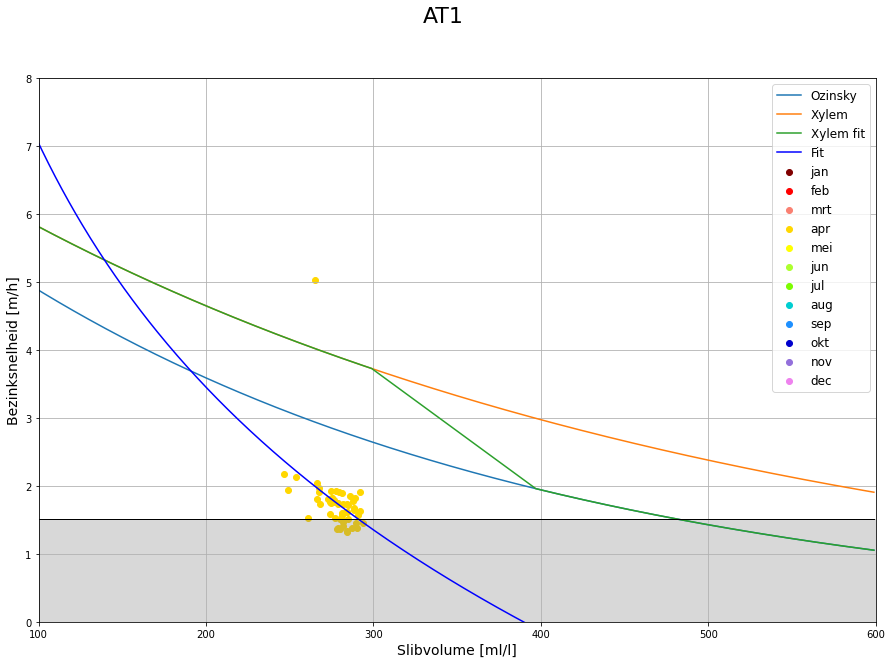

In [68]:
df1_sviplot = df1_filter.loc["2020-04-01":]
colors = {1:'maroon', 2:'red', 3: 'salmon', 4:'gold', 5:'yellow', 6:'greenyellow', 7:'lawngreen', 8: 'darkturquoise', 9: 'dodgerblue', 10: 'mediumblue',11: 'mediumpurple', 12: 'violet'}
legend = {1:"jan",2:"feb",3:"mrt",4:"apr",5:"mei",6:"jun",7:"jul",8:"aug",9:"sep",10:"okt",11:"nov",12:"dec"}
df1_sviplot = df1_sviplot.assign(Month = df1_sviplot.index.month)


fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1",fontsize=22)
ax.set_xlim(100,600)
ax.set_ylim(0,8)
ax.set_xlabel("Slibvolume [ml/l]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
for i in range(12):
    ax.scatter(x=df1_sviplot[df1_sviplot["Month"]==i+1]["Slibvolume1"], y=df1_sviplot[df1_sviplot["Month"]==i+1]['Totale snelheid1'], color=colors[i+1], label = legend[i+1])

ax.plot(t, ozinsky(t, 120), label="Ozinsky")
ax.plot(t, xylem(t, 120), label="Xylem")
ax.plot(t, xylem_fit(t, 120), label="Xylem fit")
ax.plot(t, p(np.log(t)), "b-", label = "Fit")
ax.plot(t, min_snelheid(t), color="black", linewidth=1)
#plt.axvline(x=405, color="black", linewidth=1)

#plt.axvspan(405,600, color="grey", alpha=0.3)
plt.axhspan(0,1.52, color="grey", alpha=0.3)
# plt.text(320,5.5,"Operationeel window")
#plt.text(420,5.5,"Window bezinksnelheid hoog genoeg")

plt.legend(fontsize="12")
plt.grid(which='major', axis='both')
name = loc_submap + "\AT1_Slibvolume_Bezinksnelheid_lm"
plt.savefig(name)

In [69]:
at1 = "mediumpurple"
at2 = "darkturquoise"
dwa = "red"
rwa = "dodgerblue"

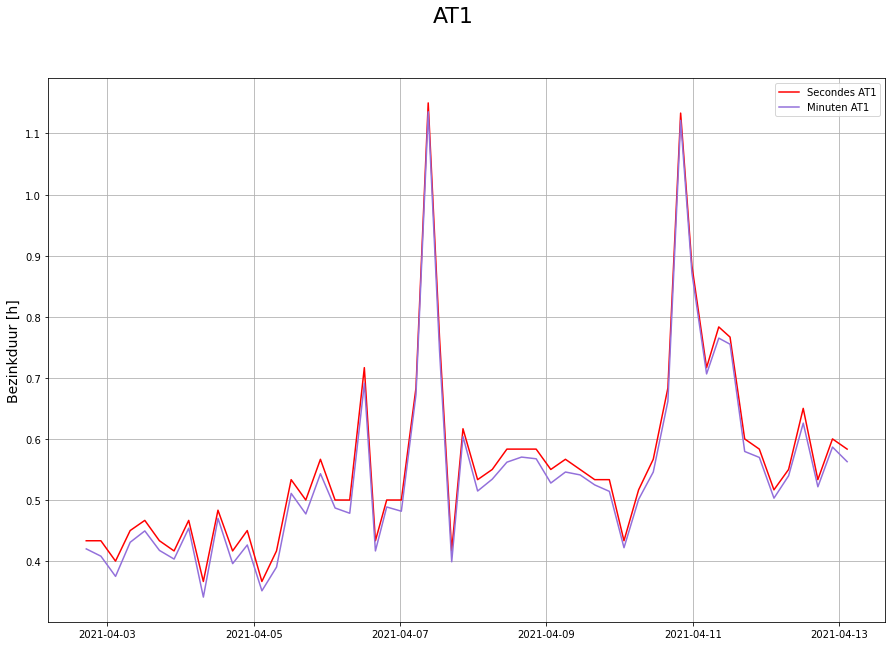

In [145]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1",fontsize=22)
ax.set_ylabel("Bezinkduur [h]", fontsize=14)
plt.grid(which='major', axis='both')
plt.plot(mdf1_filter.index, mdf1_filter["Duur1"], color='red', label="Secondes AT1")
plt.plot(df1_filter.index, df1_filter["Duur1"], color=at1, label="Minuten AT1")
plt.legend()
name = loc_map + "\AT1_Bezinkduur"
plt.savefig(name)

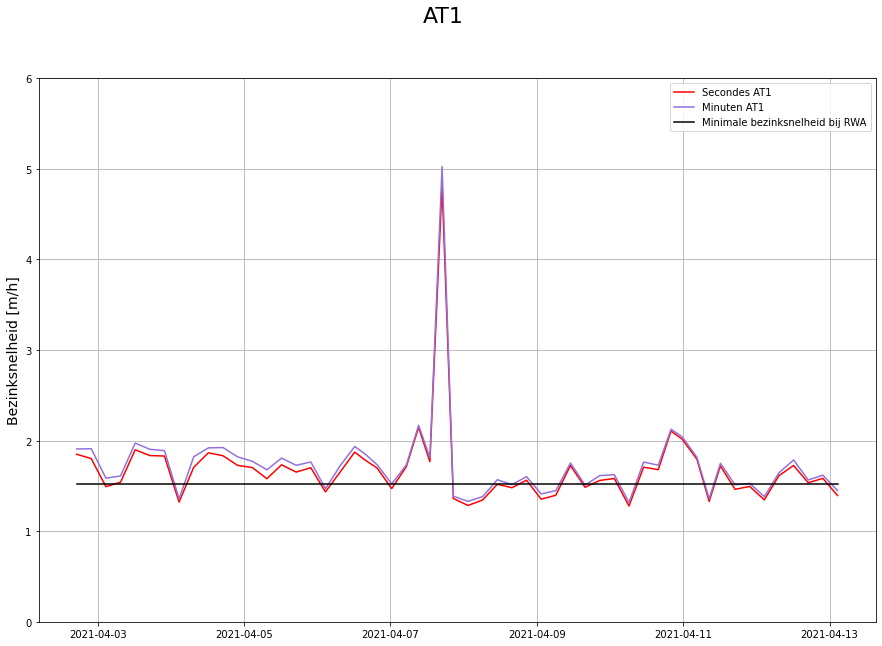

In [144]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1",fontsize=22)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
plt.grid(which='major', axis='both')
plt.plot(mdf1_filter.index, mdf1_filter["Totale snelheid1"], color='red', label="Secondes AT1")
plt.plot(df1_filter.index, df1_filter["Totale snelheid1"], color=at1, label="Minuten AT1")
ax.plot(df1_filter.index, min_snelheid(df1_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend()
ax.set_ylim(0,6)
name = loc_submap + "\AT1_Bezinksnelheid"
plt.savefig(name)

Verschil bezinksnelheid per cyclus


In [120]:
verschil = {}

for elm in mdf1_filter.index:
    # print(elm)
    verschil_index = df1_filter.index.get_loc(elm, method='nearest', tolerance=None)
    v_duur = df1_filter.iloc[verschil_index]["Duur1"] - mdf1_filter.loc[elm]["Duur1"]
    v_snelheid = df1_filter.iloc[verschil_index]["Totale snelheid1"] - mdf1_filter.loc[elm]["Totale snelheid1"]
    verschil[elm] = [elm, v_duur, v_snelheid]

In [124]:
df_verschil = pd.DataFrame.from_dict(verschil, orient="index", columns=["Start bezinking (s)", "Verschil bezinkduur (h)", "Verschil bezinksnelheid (m/h)"])

In [125]:
df_verschil.head()

,Start bezinking (s),Verschil bezinkduur (h),Verschil bezinksnelheid (m/h)
2021-04-02 17:05:00,2021-04-02 17:05:00,-0.013333,0.058221
2021-04-02 21:53:00,2021-04-02 21:53:00,-0.025278,0.108670
2021-04-03 02:41:00,2021-04-03 02:41:00,-0.025000,0.092753
2021-04-03 07:29:00,2021-04-03 07:29:00,-0.019167,0.068950
2021-04-03 12:17:00,2021-04-03 12:17:00,-0.017222,0.073980


In [126]:
df_verschil.describe()

,Verschil bezinkduur (h),Verschil bezinksnelheid (m/h)
count,55.000000,55.000000
mean,-0.017197,0.054745
std,0.005018,0.031305
min,-0.026389,0.018641
25%,-0.021389,0.034557
50%,-0.016667,0.050561
75%,-0.013056,0.067384
max,-0.008611,0.207952


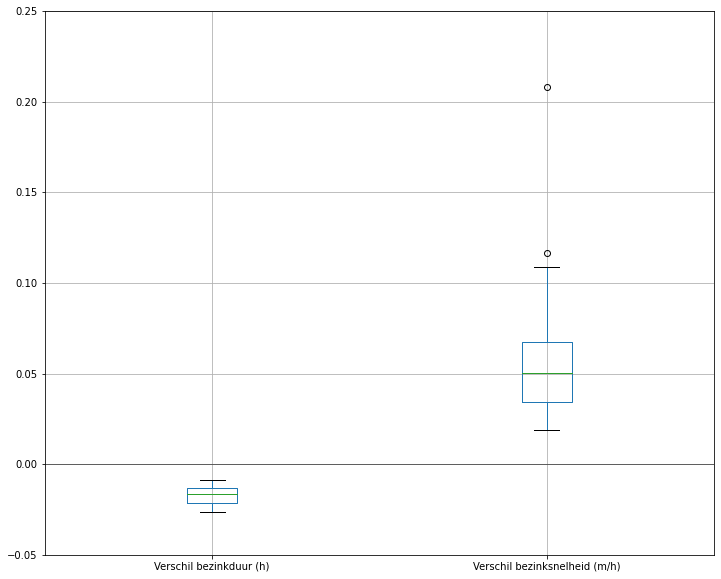

In [143]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_ylim(-0.05,0.25)
boxplot = df_verschil.boxplot()
plt.hlines(0,0.5,2.5,color="black",linewidth=0.5)
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Methode onderzoek\Secondedata\sensor_325_386\boxplot.png")